# Regression

In [1]:
#!/usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F


# Import models and training functions
from models import ConvNet, FFNet
from training import train_epochs,  kf_train_epochs
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour

#Import sys
import sys

## Data generation

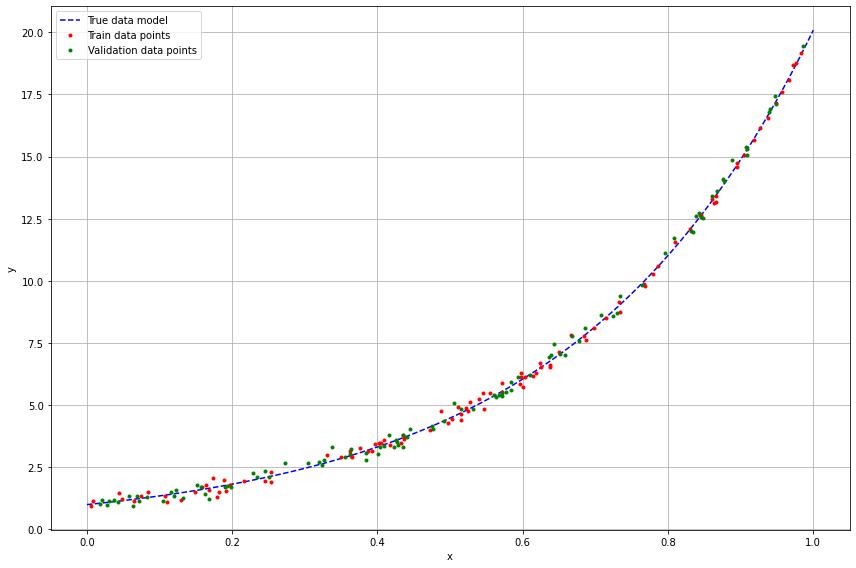

In [2]:
def exp_model(x, alpha, beta, noise_std=0):
    """
    INPUT
        x: x vector
        alpha: consant 
        beta: constant
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    noise = np.random.randn(len(x)) * noise_std
    return alpha*np.exp(beta*x) + noise

alpha = 1.0
beta = 3.0
noise_std = 0.2
np.random.seed(4)

### Train data
num_train_points = 100
x_train = np.random.rand(num_train_points)
y_train = exp_model(x_train, alpha, beta, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))
    
### Validation data
num_val_points = 100
x_val = np.random.rand(num_val_points)
y_val = exp_model(x_val, alpha, beta, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))

### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, exp_model(x_highres, alpha, beta), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Dataset and dataloader

### Dataset

In [3]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.transform = transform
        
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
            
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
            # Now self.data contains all our dataset.
            # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [4]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    


In [5]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader


In [6]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=True, num_workers=0)

## Training

In [7]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


## Hyperparameter optmization:
### Optuna framework

In [27]:
import optuna 

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log = True)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
    pow_size = trial.suggest_int("layer_size_pow", 1, 8)
    
    
    layer_size = 2**pow_size
    
    layers_sizes = [1, layer_size,2*layer_size,layer_size, 1]
    parameters = {
    "layers_sizes" : layers_sizes,
    "act" :  getattr(nn, activation_name), 
    "drop_p" : drop_p,
    }

    # Define the model
    model = FFNet(parameters)
   
    # Define the optimizer
    if optimizer_name == "Adam":
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, momentum = momentum)
        
    # Define the loss function 
    loss_function = nn.MSELoss()
    
    max_num_epochs = 10
    early_stopping = True
    train_loss, val_loss = train_epochs(model, device, train_dataloader, val_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)
    
    # Metric to be minimized is the last validation loss
    return val_loss[-1]


In [28]:
study = optuna.create_study()
study.optimize(objective, n_trials= 100)

study.best_params

[I 2022-02-10 13:38:33,510] A new study created in memory with name: no-name-86b562a4-6f0f-4d40-a6b5-6e994dfaf7ca


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:33,682] Trial 0 finished with value: 59.10915756225586 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.00025475369793916044, 'momentum': 0.6756065766011927, 'dropout': 0.7270066030831733, 'layer_size_pow': 4}. Best is trial 0 with value: 59.10915756225586.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:33,790] Trial 1 finished with value: 18.118173599243164 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.005279618485372731, 'momentum': 0.18592290776238896, 'dropout': 0.5239405716233688, 'layer_size_pow': 2}. Best is trial 1 with value: 18.118173599243164.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,070] Trial 2 finished with value: 0.3642045557498932 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0017865913186000451, 'momentum': 0.674967156971783, 'dropout': 0.14611923192508536, 'layer_size_pow': 8}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,209] Trial 3 finished with value: 56.71757125854492 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0016077200587459254, 'momentum': 0.8214590030422987, 'dropout': 0.9900781977481512, 'layer_size_pow': 3}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,320] Trial 4 finished with value: 23.574724197387695 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.01705192418696838, 'momentum': 0.2177691847465767, 'dropout': 0.2987824608539311, 'layer_size_pow': 5}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,445] Trial 5 finished with value: 31.78108787536621 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.007703810012558786, 'momentum': 0.6227636225760539, 'dropout': 0.8062826763854061, 'layer_size_pow': 3}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,559] Trial 6 finished with value: 57.107337951660156 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 1.1970042747044213e-05, 'momentum': 0.08179821581711022, 'dropout': 0.9792472876028253, 'layer_size_pow': 5}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,687] Trial 7 finished with value: 55.09666061401367 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.004374243309768786, 'momentum': 0.7344247233751545, 'dropout': 0.9761579521089296, 'layer_size_pow': 3}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,820] Trial 8 finished with value: 1.133629322052002 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.07294488251810803, 'momentum': 0.6381068198238761, 'dropout': 0.10172468384785172, 'layer_size_pow': 5}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:34,946] Trial 9 finished with value: 49.588130950927734 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0017508533843009079, 'momentum': 0.4135900285549273, 'dropout': 0.722811439743715, 'layer_size_pow': 1}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:35,246] Trial 10 finished with value: 4.635720729827881 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.00013731963834240536, 'momentum': 0.9756069135978258, 'dropout': 0.043673242450797525, 'layer_size_pow': 8}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:35,537] Trial 11 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:35,814] Trial 12 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:36,093] Trial 13 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:36,371] Trial 14 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:36,645] Trial 15 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:36,928] Trial 16 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:37,218] Trial 17 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:37,515] Trial 18 finished with value: 24.946632385253906 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.04602301432353119, 'momentum': 0.4607961334015934, 'dropout': 0.04141203114933757, 'layer_size_pow': 8}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:37,731] Trial 19 finished with value: 7.008107662200928 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.06461850355573603, 'momentum': 0.5467220167709302, 'dropout': 0.2828232375002697, 'layer_size_pow': 7}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:37,865] Trial 20 finished with value: 2.3334102630615234 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0002219898527943312, 'momentum': 0.8929762816668858, 'dropout': 0.21883553103961617, 'layer_size_pow': 6}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:37,998] Trial 21 finished with value: 55.97044372558594 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 4.050176801918447e-05, 'momentum': 0.3718733857246776, 'dropout': 0.1658276534796963, 'layer_size_pow': 6}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:38,211] Trial 22 finished with value: 3.9222168922424316 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.09489381913070066, 'momentum': 0.7848105425483609, 'dropout': 0.4035617793394173, 'layer_size_pow': 7}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:38,344] Trial 23 finished with value: 11.095516204833984 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0006156284630293968, 'momentum': 0.5404851126665162, 'dropout': 0.49145501568966876, 'layer_size_pow': 6}. Best is trial 2 with value: 0.3642045557498932.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:38,583] Trial 24 finished with value: 0.13897506892681122 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.02051033230734532, 'momentum': 0.6205884390935985, 'dropout': 0.12180616339410333, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:38,956] Trial 25 finished with value: 9.893858909606934 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.019759708232459205, 'momentum': 0.874238782934209, 'dropout': 0.38290702800306553, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:39,133] Trial 26 finished with value: 7.357099533081055 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0007134386066823293, 'momentum': 0.2552089274058186, 'dropout': 0.15174519924031085, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:39,301] Trial 27 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:39,515] Trial 28 finished with value: 0.9076502323150635 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.01820008460881607, 'momentum': 0.33817038663203436, 'dropout': 0.5430323859700663, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:39,730] Trial 29 finished with value: 0.6595062017440796 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.01795494390226896, 'momentum': 0.3843111696089483, 'dropout': 0.5523479845912327, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:40,094] Trial 30 finished with value: 0.35247331857681274 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0029821685660592536, 'momentum': 0.5259160031499651, 'dropout': 0.6338527628369224, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:40,456] Trial 31 finished with value: 5.932398319244385 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.002450187430428239, 'momentum': 0.5884675598272187, 'dropout': 0.6411656822384324, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:40,833] Trial 32 finished with value: 0.5577307939529419 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0042823539002712074, 'momentum': 0.707378291481302, 'dropout': 0.3988872690737917, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:40,995] Trial 33 finished with value: 0.5131142139434814 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.009678050583223628, 'momentum': 0.474234147634269, 'dropout': 0.2682145191206796, 'layer_size_pow': 6}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2022-02-10 13:38:41,284] Trial 34 failed, because the objective function returned nan.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:41,571] Trial 35 finished with value: 30.317901611328125 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.0006134832745583089, 'momentum': 0.5159638451044815, 'dropout': 0.8455090618948804, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:41,779] Trial 36 finished with value: 1.6222411394119263 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.03314784622019496, 'momentum': 0.759503148611312, 'dropout': 0.0016531535036045375, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:42,081] Trial 37 finished with value: 10.900056838989258 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0012841547348319614, 'momentum': 0.5937900902926947, 'dropout': 0.630015801453796, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:42,245] Trial 38 finished with value: 0.1449611485004425 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.002911200191202806, 'momentum': 0.6821275419900861, 'dropout': 0.13794762104667935, 'layer_size_pow': 6}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:42,408] Trial 39 finished with value: 15.30301284790039 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0003726292145880337, 'momentum': 0.6748800561766212, 'dropout': 0.44985921150737895, 'layer_size_pow': 6}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:42,621] Trial 40 finished with value: 0.41192251443862915 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.002716667401070839, 'momentum': 0.6636939100922851, 'dropout': 0.10712090630661236, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:42,757] Trial 41 finished with value: 3.4408068656921387 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.006431498089236939, 'momentum': 0.8311813759875621, 'dropout': 0.209447476765716, 'layer_size_pow': 4}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:42,973] Trial 42 finished with value: 0.23404540121555328 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0026252298696143846, 'momentum': 0.7041718476051494, 'dropout': 0.3413214089264883, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:43,130] Trial 43 finished with value: 15.732605934143066 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.009518194523210783, 'momentum': 0.5661224574583479, 'dropout': 0.6017455184135734, 'layer_size_pow': 6}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:43,268] Trial 44 finished with value: 2.4020183086395264 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0029831876111464104, 'momentum': 0.7120838550646201, 'dropout': 0.3287294399219851, 'layer_size_pow': 5}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:43,499] Trial 45 finished with value: 0.5144875645637512 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.000979712726556696, 'momentum': 0.46844180867157553, 'dropout': 0.2222301443747507, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:43,659] Trial 46 finished with value: 0.5997527837753296 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.010984461871431577, 'momentum': 0.6287010059212325, 'dropout': 0.3271782285542031, 'layer_size_pow': 6}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:43,795] Trial 47 finished with value: 1.2572003602981567 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.004289319946812124, 'momentum': 0.009105907340990815, 'dropout': 0.10961403407284506, 'layer_size_pow': 4}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:43,931] Trial 48 finished with value: 29.452932357788086 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.028224089356251755, 'momentum': 0.2841371653761936, 'dropout': 0.7858128995037683, 'layer_size_pow': 5}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:44,140] Trial 49 finished with value: 16.708662033081055 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0003352355260388408, 'momentum': 0.8122307664797495, 'dropout': 0.7109853979352795, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:44,427] Trial 50 finished with value: 0.16145570576190948 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0015919262021085747, 'momentum': 0.7126808276386434, 'dropout': 0.15544106784726397, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:44,714] Trial 51 finished with value: 1.0488967895507812 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0020494484132349182, 'momentum': 0.6192711875545499, 'dropout': 0.07339945503090559, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:45,077] Trial 52 finished with value: 0.3483734130859375 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0012578289483455875, 'momentum': 0.7326201804267806, 'dropout': 0.17544781876978544, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:45,285] Trial 53 finished with value: 0.44525036215782166 and parameters: {'optimizer': 'Adam', 'activation': 'ReLU', 'learning_rate': 0.0010455475240837364, 'momentum': 0.7502507275170754, 'dropout': 0.17555131010495154, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:45,398] Trial 54 finished with value: 35.60547637939453 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 8.042227501728492e-05, 'momentum': 0.902668769247748, 'dropout': 0.25662767854212076, 'layer_size_pow': 2}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:45,757] Trial 55 finished with value: 0.2452797144651413 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.001752117201678567, 'momentum': 0.7119789087747235, 'dropout': 0.009179262013847334, 'layer_size_pow': 8}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:45,927] Trial 56 finished with value: 0.31962573528289795 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.005146555577767898, 'momentum': 0.6817490145919473, 'dropout': 0.027005681443911522, 'layer_size_pow': 7}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:46,084] Trial 57 finished with value: 0.966597855091095 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0015623502717811303, 'momentum': 0.8467459831275906, 'dropout': 0.07501970375171309, 'layer_size_pow': 6}. Best is trial 24 with value: 0.13897506892681122.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:46,447] Trial 58 finished with value: 0.12150347977876663 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0007498395741793668, 'momentum': 0.9268360130997101, 'dropout': 0.12967127357355918, 'layer_size_pow': 8}. Best is trial 58 with value: 0.12150347977876663.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:46,620] Trial 59 finished with value: 4.716462135314941 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.0003949983012047055, 'momentum': 0.9831965895794218, 'dropout': 0.127378156873815, 'layer_size_pow': 7}. Best is trial 58 with value: 0.12150347977876663.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:46,984] Trial 60 finished with value: 0.11298210918903351 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0008299359554732674, 'momentum': 0.789513155781955, 'dropout': 0.07029362297804917, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:47,349] Trial 61 finished with value: 4.210174560546875 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0001621429505876359, 'momentum': 0.7885281097302678, 'dropout': 0.0647734542576941, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:47,716] Trial 62 finished with value: 0.18323276937007904 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0008763509995924457, 'momentum': 0.9653732712868102, 'dropout': 0.2076851631069584, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:48,085] Trial 63 finished with value: 0.22692452371120453 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0007087756920460889, 'momentum': 0.9252565043936196, 'dropout': 0.20732005340361623, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:48,476] Trial 64 finished with value: 0.34331053495407104 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.000524044354273761, 'momentum': 0.9469548484370572, 'dropout': 0.14514110929612845, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:48,845] Trial 65 finished with value: 1.5057638883590698 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.00023888231008353762, 'momentum': 0.8609612858230646, 'dropout': 0.09104036062911046, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:49,017] Trial 66 finished with value: 0.9352433085441589 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.0008907881320467811, 'momentum': 0.9474688234030267, 'dropout': 0.045604062664481484, 'layer_size_pow': 7}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:49,388] Trial 67 finished with value: 7.695158004760742 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.00013258666614353556, 'momentum': 0.8917414884541154, 'dropout': 0.2459749922748587, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:49,521] Trial 68 finished with value: 61.83427429199219 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0005430876522334233, 'momentum': 0.9904322562471023, 'dropout': 0.1805322925235897, 'layer_size_pow': 1}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:49,813] Trial 69 finished with value: 1.270435094833374 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.00044892776889827747, 'momentum': 0.7774755033258924, 'dropout': 0.14625862129569872, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:50,181] Trial 70 finished with value: 0.1429567188024521 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0008032096221782213, 'momentum': 0.9235248655882181, 'dropout': 0.19540003726654237, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:50,548] Trial 71 finished with value: 54.10346221923828 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 1.5547646141736702e-05, 'momentum': 0.9466501770498692, 'dropout': 0.30016756795471494, 'layer_size_pow': 8}. Best is trial 60 with value: 0.11298210918903351.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:50,916] Trial 72 finished with value: 0.09718067198991776 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.000905261307068349, 'momentum': 0.8063075258413864, 'dropout': 0.1223216373580507, 'layer_size_pow': 8}. Best is trial 72 with value: 0.09718067198991776.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:51,129] Trial 73 finished with value: 5.938515663146973 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.00028939615245379187, 'momentum': 0.8329061200574475, 'dropout': 0.11491568525698888, 'layer_size_pow': 7}. Best is trial 72 with value: 0.09718067198991776.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:51,495] Trial 74 finished with value: 0.1530449539422989 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0012016035018312685, 'momentum': 0.8704975548635153, 'dropout': 0.04854322827512353, 'layer_size_pow': 8}. Best is trial 72 with value: 0.09718067198991776.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:51,863] Trial 75 finished with value: 0.12389910966157913 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0007509509054559068, 'momentum': 0.8104577652909983, 'dropout': 0.04106397103578291, 'layer_size_pow': 8}. Best is trial 72 with value: 0.09718067198991776.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:52,074] Trial 76 finished with value: 12.627227783203125 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.00018329728347033915, 'momentum': 0.8143324573539343, 'dropout': 0.08519464978411473, 'layer_size_pow': 7}. Best is trial 72 with value: 0.09718067198991776.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:52,439] Trial 77 finished with value: 0.09324976801872253 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0008090837025635179, 'momentum': 0.7855145931784661, 'dropout': 0.02516562491188158, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:52,804] Trial 78 finished with value: 0.25890347361564636 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0007250883716901363, 'momentum': 0.9101829629516924, 'dropout': 0.004826836515798669, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:52,938] Trial 79 finished with value: 54.60615921020508 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.00042476880089777606, 'momentum': 0.7867717368697913, 'dropout': 0.03611805690747087, 'layer_size_pow': 3}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:53,310] Trial 80 finished with value: 0.14288806915283203 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0008488322006531417, 'momentum': 0.6552899573184403, 'dropout': 0.12605308441400567, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:53,679] Trial 81 finished with value: 0.43046632409095764 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0008417111662352689, 'momentum': 0.649715155766246, 'dropout': 0.10040536442283444, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:54,048] Trial 82 finished with value: 0.20625482499599457 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0006031306273298228, 'momentum': 0.8092352197904806, 'dropout': 0.05945372385842785, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:54,415] Trial 83 finished with value: 0.8186836838722229 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.000293418983678737, 'momentum': 0.8715175630981215, 'dropout': 0.12426276656397345, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:54,783] Trial 84 finished with value: 0.4254341721534729 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.001316927246707863, 'momentum': 0.7484504398843782, 'dropout': 0.19057921834507272, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:54,996] Trial 85 finished with value: 1.4192396402359009 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0005144921540825059, 'momentum': 0.5765035123862198, 'dropout': 0.08560545988544443, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:55,360] Trial 86 finished with value: 0.10401348024606705 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0010599733307484727, 'momentum': 0.7726392272156215, 'dropout': 0.028594178966298907, 'layer_size_pow': 8}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:55,573] Trial 87 finished with value: 0.09969672560691833 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0020949427450656405, 'momentum': 0.7714877102665196, 'dropout': 0.025481877664021078, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:55,783] Trial 88 finished with value: 0.22157558798789978 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.002156097673805511, 'momentum': 0.7693182987745644, 'dropout': 0.018833496747887965, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:55,994] Trial 89 finished with value: 0.13634996116161346 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0013835054711219294, 'momentum': 0.8048060922065495, 'dropout': 0.031994983725506354, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:56,206] Trial 90 finished with value: 0.6216284036636353 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.003484957880062983, 'momentum': 0.7991709758699579, 'dropout': 0.03457222243890057, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:56,418] Trial 91 finished with value: 0.3145160973072052 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.001069772455937439, 'momentum': 0.8449916128075645, 'dropout': 0.05586058029912874, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:56,630] Trial 92 finished with value: 32.14716720581055 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.06321014039504855, 'momentum': 0.7245405500201922, 'dropout': 0.00306192225355199, 'layer_size_pow': 7}. Best is trial 77 with value: 0.09324976801872253.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:56,998] Trial 93 finished with value: 0.08737574517726898 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0016018623049032798, 'momentum': 0.8339205700053602, 'dropout': 0.06811654716105063, 'layer_size_pow': 8}. Best is trial 93 with value: 0.08737574517726898.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:57,392] Trial 94 finished with value: 0.07612427324056625 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0015368120863261672, 'momentum': 0.1616810865684824, 'dropout': 0.02568137461424888, 'layer_size_pow': 8}. Best is trial 94 with value: 0.07612427324056625.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:57,760] Trial 95 finished with value: 0.07529694586992264 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.001949672449231691, 'momentum': 0.2333819603917798, 'dropout': 0.07916104156485718, 'layer_size_pow': 8}. Best is trial 95 with value: 0.07529694586992264.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:58,127] Trial 96 finished with value: 0.42933985590934753 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0020588367204147843, 'momentum': 0.205799463889991, 'dropout': 0.07141078618139227, 'layer_size_pow': 8}. Best is trial 95 with value: 0.07529694586992264.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:58,496] Trial 97 finished with value: 0.4362180531024933 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.003450078271160508, 'momentum': 0.2568728305236557, 'dropout': 0.10208362277362724, 'layer_size_pow': 8}. Best is trial 95 with value: 0.07529694586992264.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:58,867] Trial 98 finished with value: 0.5041223168373108 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0017185266042462446, 'momentum': 0.0508002829851992, 'dropout': 0.06321921577651822, 'layer_size_pow': 8}. Best is trial 95 with value: 0.07529694586992264.


Network initialized


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-10 13:38:59,232] Trial 99 finished with value: 30.58618927001953 and parameters: {'optimizer': 'Adam', 'activation': 'LeakyReLU', 'learning_rate': 0.0022101984889069948, 'momentum': 0.13859632796764715, 'dropout': 0.901080196444545, 'layer_size_pow': 8}. Best is trial 95 with value: 0.07529694586992264.


{'optimizer': 'Adam',
 'activation': 'LeakyReLU',
 'learning_rate': 0.001949672449231691,
 'momentum': 0.2333819603917798,
 'dropout': 0.07916104156485718,
 'layer_size_pow': 8}

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

## Best model

In [ ]:
# Retrieve best paramaters
bp = study.best_params

# Define filename where to save model
filename = "FFNet_best.torch"

# Define the network
layers_sizes = [1, 2**bp["layer_size_pow"],2*2**bp["layer_size_pow"],2**bp["layer_size_pow"], 1]


parameters = {
    "layers_sizes" : layers_sizes,
    "act" : getattr(nn, bp["activation"]), 
    "drop_p" : bp["dropout"]
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)


In [ ]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
if bp["optimizer"] == "Adam":
    optimizer = getattr(optim, bp["optimizer"])(net.parameters(), lr = bp["learning_rate"])
else:
    optimizer = getattr(optim, bp["optimizer"])(net.parameters(), lr = bp["learning_rate"], momentum = bp["momentum"])

# Training
max_num_epochs = 1000
early_stopping = True
train_loss_best, val_loss_best = train_epochs(net, device, train_dataloader, val_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_best, label='Train loss')
ax1.semilogy(val_loss_best, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

### Save network parameters

### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)

## K-fold cross validation

In [38]:
# Retrieve best paramaters
bp = study.best_params

# Define filename where to save model
filename = "FFNet_kf.torch"

# Define the network
layers_sizes = [1, 2**bp["layer_size_pow"],2*2**bp["layer_size_pow"],2**bp["layer_size_pow"], 1]


parameters = {
    "layers_sizes" : layers_sizes,
    "act" : getattr(nn, bp["activation"]), 
    "drop_p" : bp["dropout"]
}


# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)


Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Dropout(p=0.07916104156485718, inplace=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): Dropout(p=0.07916104156485718, inplace=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Dropout(p=0.07916104156485718, inplace=False)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [39]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
if bp["optimizer"] == "Adam":
    optimizer = getattr(optim, bp["optimizer"])(net.parameters(), lr = bp["learning_rate"])
else:
    optimizer = getattr(optim, bp["optimizer"])(net.parameters(), lr = bp["learning_rate"], momentum = bp["momentum"])

# K-fold cross validation training
max_num_epochs = 1000
early_stopping = False
mean_train, std_train, mean_val, std_val = kf_train_epochs(net, device,  5, 4, train_dataset, val_dataloader, loss_function, optimizer, max_num_epochs,  early_stopping)



  0%|          | 0/1000 [00:00<?, ?it/s]

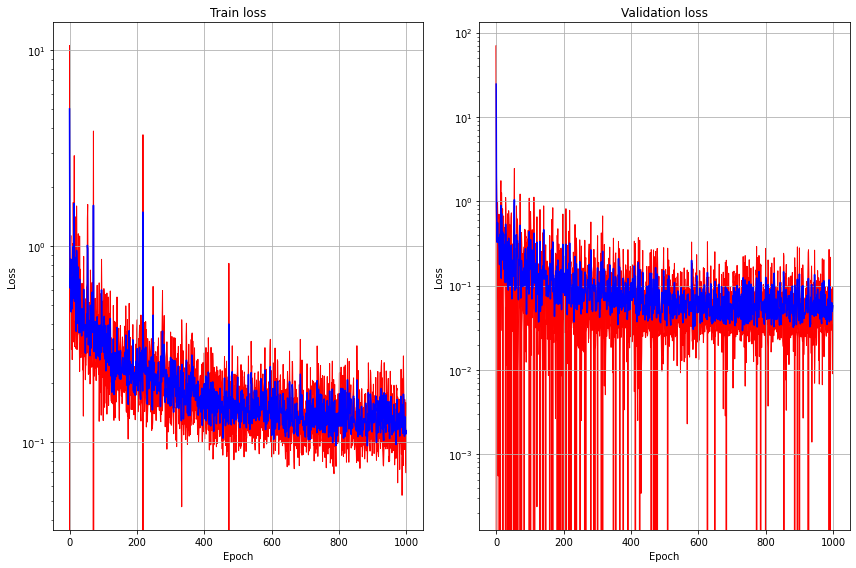

In [43]:
### Plot k-fold losses

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
ax1.semilogy(mean_train, c = "b")
ax1.fill_between(np.array(range(max_num_epochs)), np.subtract(mean_train,std_train), np.add(mean_train, std_train), color = "r")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.set_title("Train loss")

ax2 = fig.add_subplot(122)
ax2.semilogy(mean_val, c = "b")
ax2.fill_between(np.array(range(max_num_epochs)), np.subtract(mean_val,std_val), np.add(mean_val, std_val), color = "r")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid()
ax2.set_title("Validation loss")

plt.tight_layout()
plt.show()

### Save network parameters

### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)

## Network Analysis

In [45]:
### Load network state
net_name = "FFNet_kf.torch"

# Load the state dict previously saved
net_dict = torch.load(net_name)
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = FFNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

In [56]:
# Input vector
x_vec = torch.linspace(0.0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Expected output
true_model = exp_model(x_vec, alpha, beta).squeeze()





Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


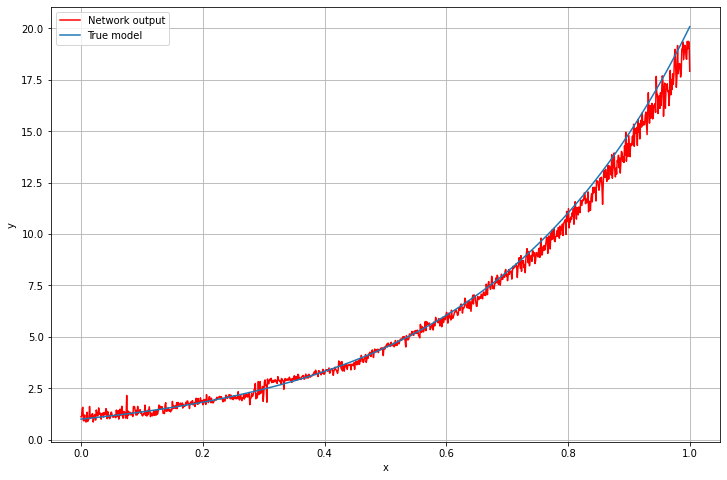

In [57]:


# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output', c = "r" )
plt.plot(x_vec, true_model, label = "True model")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### Access network parameters

In [58]:
# First hidden layer
h1_w = net.layers[0].weight.data.cpu().numpy()
h1_b = net.layers[0].bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.layers[3].weight.data.cpu().numpy()
h2_b = net.layers[3].bias.data.cpu().numpy()

# Third hidden layer
h3_w = net.layers[6].weight.data.cpu().numpy()
h3_b = net.layers[6].bias.data.cpu().numpy()

# Output layer
h4_w = net.layers[9].weight.data.cpu().numpy()
h4_b = net.layers[9].bias.data.cpu().numpy()

### Weight histogram

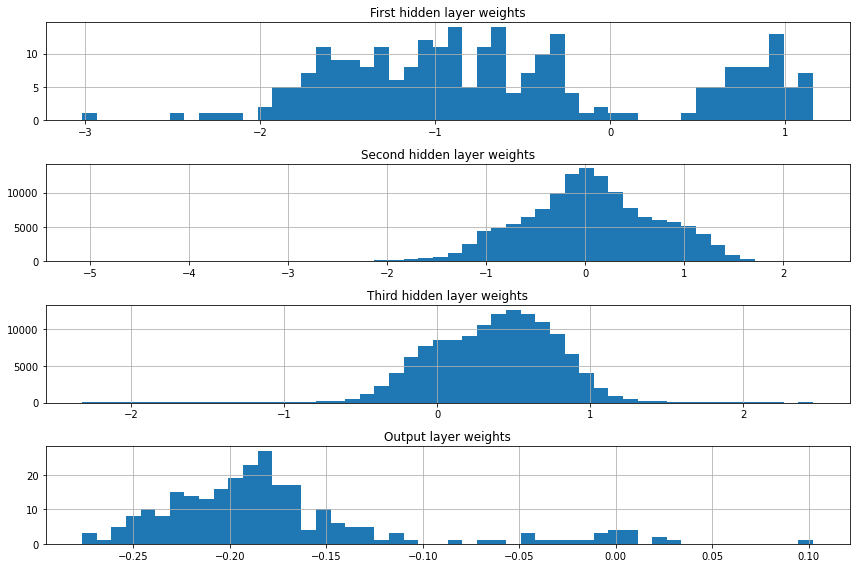

In [61]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(h4_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

### Analyze activation

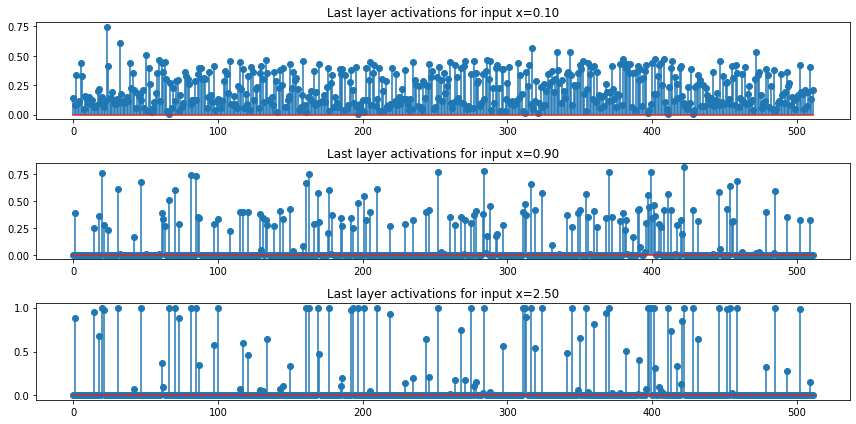

In [63]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.layers[3].register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()